In [7]:
!pip install torchvision timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 18.5 MB/s eta 0:00:00m eta 0:00:0136m0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 436.4/436.4 kB 44.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 381.5/381.5 kB 37.1 MB/s eta 0:00:00

[notice] A new release of pip available: 22.3.1 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [58]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import timm

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

# ℹ️ Load Data

In [11]:
class PlayingCardDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data = ImageFolder(data_dir, transform=transform)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

    @property
    def classes(self):
        return self.data.classes

In [15]:
dataset = PlayingCardDataset(
    data_dir='./archive/train'
)

In [17]:
len(dataset)

7624

In [19]:
dataset[5]

(<PIL.Image.Image image mode=RGB size=224x224>, 0)

In [20]:
image, label = dataset[6000]

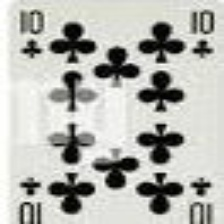

In [21]:
image

In [22]:
# Create a dictionary of labels for each number in the dataset
data_dir = './archive/train'
target_to_class = {v: k for k, v in ImageFolder(data_dir).class_to_idx.items()}
print(target_to_class)

{0: 'ace of clubs', 1: 'ace of diamonds', 2: 'ace of hearts', 3: 'ace of spades', 4: 'eight of clubs', 5: 'eight of diamonds', 6: 'eight of hearts', 7: 'eight of spades', 8: 'five of clubs', 9: 'five of diamonds', 10: 'five of hearts', 11: 'five of spades', 12: 'four of clubs', 13: 'four of diamonds', 14: 'four of hearts', 15: 'four of spades', 16: 'jack of clubs', 17: 'jack of diamonds', 18: 'jack of hearts', 19: 'jack of spades', 20: 'joker', 21: 'king of clubs', 22: 'king of diamonds', 23: 'king of hearts', 24: 'king of spades', 25: 'nine of clubs', 26: 'nine of diamonds', 27: 'nine of hearts', 28: 'nine of spades', 29: 'queen of clubs', 30: 'queen of diamonds', 31: 'queen of hearts', 32: 'queen of spades', 33: 'seven of clubs', 34: 'seven of diamonds', 35: 'seven of hearts', 36: 'seven of spades', 37: 'six of clubs', 38: 'six of diamonds', 39: 'six of hearts', 40: 'six of spades', 41: 'ten of clubs', 42: 'ten of diamonds', 43: 'ten of hearts', 44: 'ten of spades', 45: 'three of clu

In [23]:
# Output images in same size
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

In [24]:
# Create dataset
dataset = PlayingCardDataset(data_dir, transform)

In [26]:
# Image is now a PyTorch tensor instead of a PIL image
image, label = dataset[100]
image.shape

torch.Size([3, 128, 128])

In [28]:
# Iterate over the dataset
for image, label in dataset:
    break

# DataLoaders

In [30]:
# Shuffle when training
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [36]:
for images, labels in dataloader:
    break

In [37]:
images.shape, labels.shape

(torch.Size([32, 3, 128, 128]), torch.Size([32]))

In [38]:
labels

tensor([34,  4, 52, 39, 40, 21,  5, 12, 51, 48, 16,  5,  8, 52, 11, 30,  3, 16,
        51, 20, 19, 31, 20, 10, 25, 12,  8, 45, 37, 32, 23, 16])

# Create PyTorch Model

In [41]:
# timm has state of the art architectures pre-defined
class SimpleCardClassifier(nn.Module):
    def __init__(self, num_classes=53):
        super(SimpleCardClassifier, self).__init__()
        self.base_model = timm.create_model('efficientnet_b0', pretrained=True)
        self.features = nn.Sequential(*list(self.base_model.children())[:-1])
        
        enet_out_size = 1280
        # Make a classifier
        self.classifier = nn.Linear(enet_out_size, num_classes)

    def forward(self, x):
        x = self.features(x)
        output = self.classifier(x)
        return output

In [43]:
model = SimpleCardClassifier(num_classes=53)
print(str(model)[:500])

SimpleCardClassifier(
  (base_model): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=Fa


In [45]:
example_output = model(images)
example_output.shape

torch.Size([32, 53])

# Train the Model

In [46]:
# Loss function
criterion = nn.CrossEntropyLoss()
# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [50]:
train_folder = './archive/train'
test_folder = './archive/test'
val_folder = './archive/valid'

In [51]:
train_dataset = PlayingCardDataset(train_folder, transform=transform)
val_dataset = PlayingCardDataset(val_folder, transform=transform)
test_dataset = PlayingCardDataset(test_folder, transform=transform)

In [53]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [65]:
num_epoch = 5
train_losses, val_losses = [], []

model = SimpleCardClassifier(num_classes=53)

In [57]:
device = torch.device('cude:0' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [63]:
#check for gpu
if torch.backends.mps.is_available():
   mps_device = torch.device("mps:0")
   x = torch.ones(1, device=mps_device)
   print (x)
else:
   print ("MPS device not found.")

tensor([1.], device='mps:0')


In [66]:
for epoch in range(num_epoch):
    model.train()
    model.to(mps_device)
    running_loss = 0.0
    for images, labels in tqdm(train_loader, desc='Training loop'):
        images, labels = images.to(mps_device), labels.to(mps_device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)

    # Validation phase
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc='Validation loop'):
            images, labels = images.to(mps_device), labels.to(mps_device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
    val_loss = running_loss / len(val_loader.dataset)
    val_losses.append(val_loss)

    # print each epoch
    print(f'Epoch {epoch+1}/{num_epoch} - Train loss: {train_loss}, Validation Loss: {val_loss}')

Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 1/5 - Train loss: 4.010624739455777, Validation Loss: 3.9939087723785978


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 2/5 - Train loss: 4.011677137076667, Validation Loss: 4.004447938811104


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 3/5 - Train loss: 4.009739147028167, Validation Loss: 4.00691424495769


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 4/5 - Train loss: 4.011211414277116, Validation Loss: 4.001503134673497


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 5/5 - Train loss: 4.010205211319178, Validation Loss: 4.002366719155941


# Visualize Losses

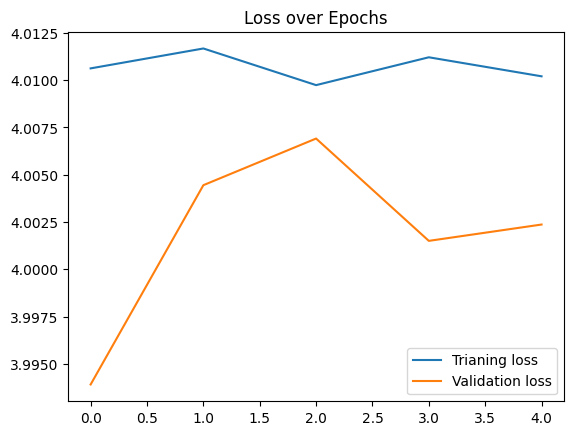

In [67]:
plt.plot(train_losses, label='Trianing loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.title('Loss over Epochs')
plt.show()

# Evaluate Model